In [2]:
import numpy as np
import pandas as pd
from spec_id import RT_spec
import matplotlib.pyplot as plt
from vtl.Readfile import Readfile
from glob import glob
from astropy.io import fits, ascii
from astropy.table import Table
from scipy.interpolate import interp1d
from time import time
import os
import cPickle
import seaborn as sea
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in","ytick.direction": "in"})
colmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.1, as_cmap=True)

In [3]:
qgDB = pd.read_pickle('../data/quiescent_gal_DB.pkl')
gsDB = qgDB[qgDB['spec'] == True]

In [5]:
gsDB

,gids,ids,redshift,hmag,ra,dec,agn,in_data,spec,flt_files,flt_xpos,flt_ypos
43,n14713,14713,1.134,22.557517,189.236333,62.214608,False,True,True,../../../Clear_data/flt_files/icat12tqq_flt.fits,480.823147,636.879341
47,n15616,15616,1.250,23.162718,189.238403,62.218809,False,True,True,../../../Clear_data/flt_files/icat12tqq_flt.fits,557.760340,731.676403
49,n16758,16758,0.992,21.618617,189.162357,62.224840,False,True,True,../../../Clear_data/flt_files/icxt36jqq_flt.fits,103.350402,901.345306
50,n17070,17070,1.226,21.592234,189.268086,62.226445,False,True,True,../../../Clear_data/flt_files/icat25hcq_flt.fits,637.268350,823.317758
51,n17436,17436,0.869,22.379914,189.171078,62.227726,False,True,True,../../../Clear_data/flt_files/icxt36jmq_flt.fits,20.935569,1013.208080
58,n19442,19442,1.007,23.317546,189.123036,62.237460,False,True,True,../../../Clear_data/flt_files/icat03dzq_flt.fits,30.768618,1009.307349
61,n21156,21156,1.201,21.327907,189.239409,62.247548,False,True,True,../../../Clear_data/flt_files/icxt51jvq_flt.fits,279.865494,838.707094
62,n21427,21427,1.479,22.540644,189.368121,62.247344,False,True,True,../../../Clear_data/flt_files/icat26dyq_flt.fits,-19.664813,572.418137
68,n23254,23254,1.457,23.460559,189.349606,62.255761,False,True,True,../../../Clear_data/flt_files/icat26dyq_flt.fits,290.163896,661.958820
69,n23435,23435,1.092,22.902048,189.338306,62.256571,False,True,True,../../../Clear_data/flt_files/icat26dyq_flt.fits,422.330798,604.972381


In [4]:
s_spec = RT_spec('../data/galaxy_flts/s39170_flt.fits','s39170')

No TEAL-based tasks available for this package!


../data/galaxy_flts/s39170_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39170_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39170_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39170_flt: save ../data/galaxy_flts/s39170_flt.detect_seg.fits, ../data/galaxy_flts/s39170_flt.detect.cat


In [14]:
start = time()
mfls=np.zeros([5000,len(s_spec.gal_wv)])

for i in range(5000):
    s_spec.Sim_spec(0.015,3.5,0,1.023)
    mfls[i]=s_spec.fl
end = time()

vchi = np.sum(((s_spec.gal_fl - mfls) / s_spec.gal_er) ** 2, axis=1).reshape(5000).astype(np.float128).T
print end - start

start = time()
chi = np.zeros(5000)

for i in range(5000):
    s_spec.Sim_spec(0.015,3.5,0,1.023)
    chi[i] = sum(((s_spec.gal_fl - s_spec.fl)/s_spec.gal_er)**2)
end = time()
print end - start

133.814237833


133.90580821


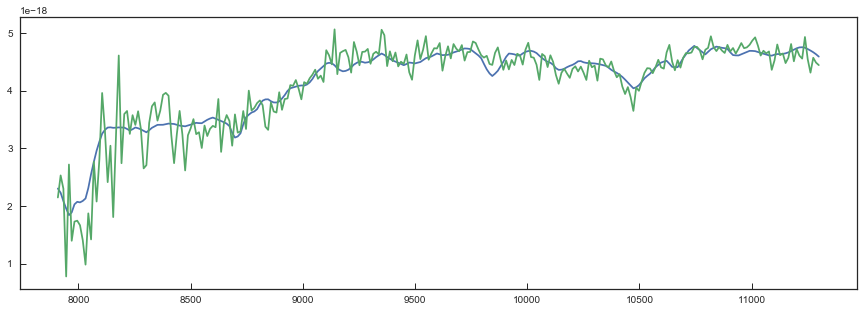

In [7]:
%matplotlib inline

plt.figure(figsize=[15,5])
plt.plot(s_spec.gal_wv[s_spec.gal_wv < 11500],s_spec.fl[s_spec.gal_wv < 11500])
plt.plot(s_spec.gal_wv,s_spec.gal_fl)
plt.show()
plt.close()

In [12]:
np.sum(((s_spec.gal_fl - mfls) / s_spec.gal_er) ** 2, axis=1).reshape(1000).astype(np.float128).T

array([ 291.19799,  291.19799,  291.19799,  291.19799,  291.19799,
        291.19799,  291.19799,  291.19799,  291.19799,  291.19799,
        291.19799,  291.19799,  291.19799,  291.19799,  291.19799,
        291.19799,  291.19799,  291.19799,  291.19799,  291.19799,
        291.19799,  291.19799,  291.19799,  291.19799,  291.19799,
        291.19799,  291.19799,  291.19799,  291.19799,  291.19799,
        291.19799,  291.19799,  291.19799,  291.19799,  291.19799,
        291.19799,  291.19799,  291.19799,  291.19799,  291.19799,
        291.19799,  291.19799,  291.19799,  291.19799,  291.19799,
        291.19799,  291.19799,  291.19799,  291.19799,  291.19799,
        291.19799,  291.19799,  291.19799,  291.19799,  291.19799,
        291.19799,  291.19799,  291.19799,  291.19799,  291.19799,
        291.19799,  291.19799,  291.19799,  291.19799,  291.19799,
        291.19799,  291.19799,  291.19799,  291.19799,  291.19799,
        291.19799,  291.19799,  291.19799,  291.19799,  291.19

In [12]:
mfl

array([             nan,              nan,              nan,
                    nan,              nan,              nan,
                    nan,              nan,              nan,
                    nan,              nan,              nan,
                    nan,              nan,              nan,
                    nan,              nan,              nan,
                    nan,              nan,              nan,
                    nan,              nan,              nan,
                    inf,              inf,              inf,
         1.19567069e+00,   1.47935167e+00,   1.44381418e+00,
         1.37818170e+00,   1.29388791e+00,   1.32008929e+00,
         1.44913012e+00,   1.56886791e+00,   1.59246409e+00,
         1.47422009e+00,   1.36195775e+00,   1.20276436e+00,
         1.19807010e+00,   1.34642203e+00,   1.42568464e+00,
         1.44246873e+00,   1.44823308e+00,   1.50249996e+00,
         1.53437385e+00,   1.42470125e+00,   1.24090201e+00,
         1.30427144e+00,